In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from scipy.stats import pearsonr

# **1. 读取数据**
df = pd.read_excel(r"C:\Users\Lyttl\Desktop\rice\ninanjie\data\combinedflower16.xlsx", header=None)

# **2. 处理数据格式**
df.columns = df.iloc[0]  # 第一行变成列名（样本名）
df = df.iloc[1:]  # 删除第一行
df.set_index(df.columns[0], inplace=True)  # 第一列 (基因 ID) 作为索引
df.index.name = "gene"

# **3. 确保所有数据是数值型**
df = df.apply(pd.to_numeric, errors="coerce")  # 转换为数值

# **4. 提取目标变量 (y) 和 特征矩阵 (X)**
# Flowering 是行名，提取 Flowering 行作为目标变量 y
y = df.loc["Flowering"].astype(float)  # Flowering 行作为目标变量
X = df.drop(index=["Flowering"]).T  # 删除 Flowering 行，并转置使样本为行，基因为列

print("转置前 X 形状:", df.drop(index=["Flowering"]).shape)
print("转置后 X 形状:", X.shape)
print("目标变量 y 形状:", y.shape)

# **5. 处理缺失值**
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# **6. 进行标准化**
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns, index=X.index)

# **7. 特征选择**
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_scaled, y)
selector = SelectFromModel(rf_model, max_features=10000, threshold="mean")
X_selected = selector.transform(X_scaled)
print("选择的特征数:", X_selected.shape[1])

# **8. 对目标变量 (y) 进行对数变换**
transformer = FunctionTransformer(np.log1p, validate=True)
y_transformed = transformer.fit_transform(y.values.reshape(-1, 1)).ravel()

# **9. 交叉验证 (KFold)**
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# **10. 随机森林超参数优化**
param_grid_rf = {
    'n_estimators': [50, 100, 150],  
    'max_depth': [5, 10, 15, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False]  
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1),
                               param_grid_rf, cv=kf, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_selected, y_transformed)
best_rf_model = grid_search_rf.best_estimator_

# **11. 评估函数**
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    pcc, _ = pearsonr(y_true, y_pred)
    return mse, r2, mae, rmse, pcc

# **12. 训练 & 评估**
def train_and_evaluate(model, X_train, X_val, X_test, y_train, y_val, y_test):
    model.fit(X_train, y_train)
    mse_train, r2_train, mae_train, rmse_train, pcc_train = evaluate(model, X_train, y_train)
    mse_val, r2_val, mae_val, rmse_val, pcc_val = evaluate(model, X_val, y_val)
    mse_test, r2_test, mae_test, rmse_test, pcc_test = evaluate(model, X_test, y_test)
    
    return r2_train, r2_val, r2_test, mse_train, mse_val, mse_test, mae_train, mae_val, mae_test, rmse_train, rmse_val, rmse_test, pcc_train, pcc_val, pcc_test

# **13. 数据集划分**
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_transformed, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **14. 评估模型**
metrics_rf = train_and_evaluate(best_rf_model, X_train, X_val, X_test, y_train, y_val, y_test)

# **15. 输出评估结果**
def print_metrics(name, metrics):
    r2_train, r2_val, r2_test = metrics[0], metrics[1], metrics[2]
    mse_train, mse_val, mse_test = metrics[3], metrics[4], metrics[5]
    mae_train, mae_val, mae_test = metrics[6], metrics[7], metrics[8]
    rmse_train, rmse_val, rmse_test = metrics[9], metrics[10], metrics[11]
    pcc_train, pcc_val, pcc_test = metrics[12], metrics[13], metrics[14]
    
    print(f"模型：{name}")
    print("=" * 50)
    print(f"{'指标':<10} {'训练集':>12} {'验证集':>12} {'测试集':>12}")
    print("-" * 50)
    print(f"{'R²':<10} {r2_train:12.4f} {r2_val:12.4f} {r2_test:12.4f}")
    print(f"{'MSE':<10} {mse_train:12.4f} {mse_val:12.4f} {mse_test:12.4f}")
    print(f"{'MAE':<10} {mae_train:12.4f} {mae_val:12.4f} {mae_test:12.4f}")
    print(f"{'RMSE':<10} {rmse_train:12.4f} {rmse_val:12.4f} {rmse_test:12.4f}")
    print(f"{'PCC':<10} {pcc_train:12.4f} {pcc_val:12.4f} {pcc_test:12.4f}")
    print("=" * 50)

print_metrics("Random Forest with Tuning", metrics_rf)


转置前 X 形状: (24175, 383)
转置后 X 形状: (383, 24175)
目标变量 y 形状: (383,)


C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


选择的特征数: 1904
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
模型：Random Forest with Tuning
指标                  训练集          验证集          测试集
--------------------------------------------------
R²               0.9986       0.3980       0.4879
MSE              0.0001       0.0553       0.0497
MAE              0.0080       0.1976       0.1834
RMSE             0.0110       0.2352       0.2229
PCC              0.9997       0.7033       0.7893


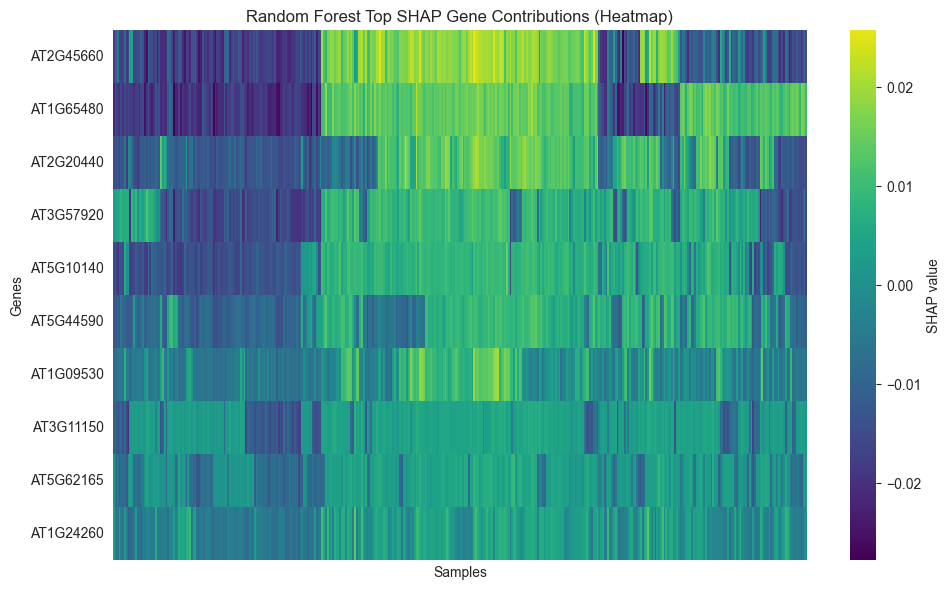

In [3]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list

# === 准备数据 === #
# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含 SHAP 值计算输入
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# SHAP 值
explainer = shap.Explainer(best_rf_model)
shap_values = explainer.shap_values(X_selected_df)  # (n_samples, n_features)

# 转换为 DataFrame，方便处理
shap_df = pd.DataFrame(shap_values, columns=X_selected_df.columns)

# === 筛选 SHAP 值 Top10 特征（按平均绝对值） === #
top_genes = shap_df.abs().mean().sort_values(ascending=False).head(10).index.tolist()
shap_top_df = shap_df[top_genes]

# === 样本聚类（列） === #
col_linkage = linkage(shap_top_df.T, method='ward')
col_order = leaves_list(linkage(shap_top_df, method='ward'))

# === 可视化：热图 === #
plt.figure(figsize=(10, 6))
sns.heatmap(
    shap_top_df.iloc[col_order].T,  # 行为基因，列为样本
    cmap='viridis',  # 文献配色：黄色→蓝紫
    center=0,
    xticklabels=False,
    yticklabels=top_genes,
    cbar_kws={'label': 'SHAP value'}
)
plt.title("Random Forest Top SHAP Gene Contributions (Heatmap)")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取特征重要性
feature_importances = best_rf_model.feature_importances_
feature_names = X.columns[selector.get_support()]  # 获取被选中的特征名称

# 创建 DataFrame 并按重要性排序
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# 画出特征重要性条形图
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Most Important Features')
plt.show()


NameError: name 'best_rf_model' is not defined

In [2]:
import shap
import matplotlib.pyplot as plt

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 使用训练好的模型来生成SHAP值
explainer = shap.Explainer(best_rf_model)
shap_values = explainer.shap_values(X_selected_df)

# 可视化前10个特征的重要性
shap.summary_plot(shap_values, X_selected_df, max_display=10)

# 如果你想要更清晰的单独显示特征重要性的条形图
shap.summary_plot(shap_values, X_selected_df, plot_type="bar", max_display=10)

# 打印前10个重要特征
shap_values_df = pd.DataFrame(shap_values[0], columns=X_selected_df.columns)
mean_shap_values = shap_values_df.abs().mean().sort_values(ascending=False)
top_10_features = mean_shap_values.head(10)
print("Top 10 Features by SHAP Value Importance:")
print(top_10_features)


C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'pd' is not defined

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

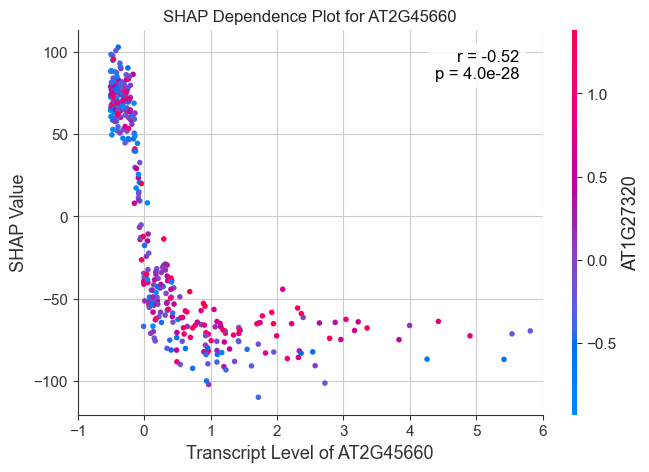

In [28]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT2G45660"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000*4

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)

    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

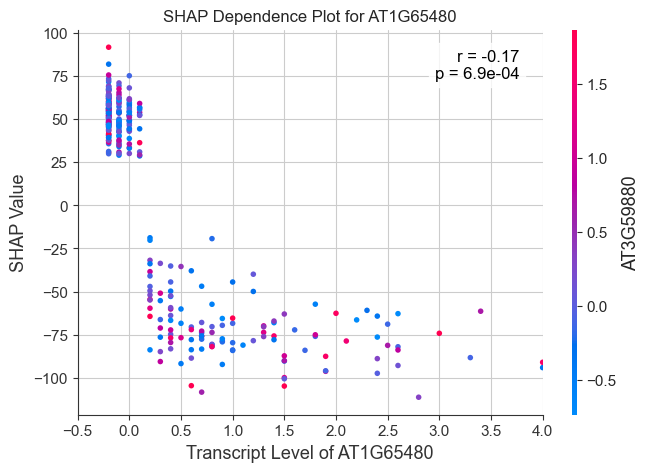

In [31]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT1G65480"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 4000

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)
    correlation=    correlation
    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-0.5, 4)

    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

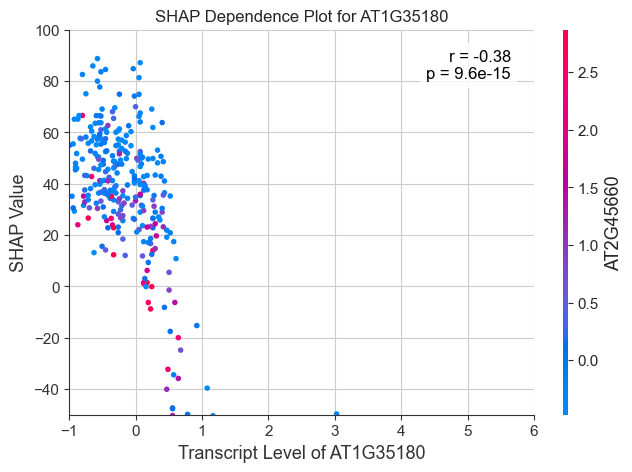

In [33]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT1G35180"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000*25

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)
    plt.ylim(-50, 100)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

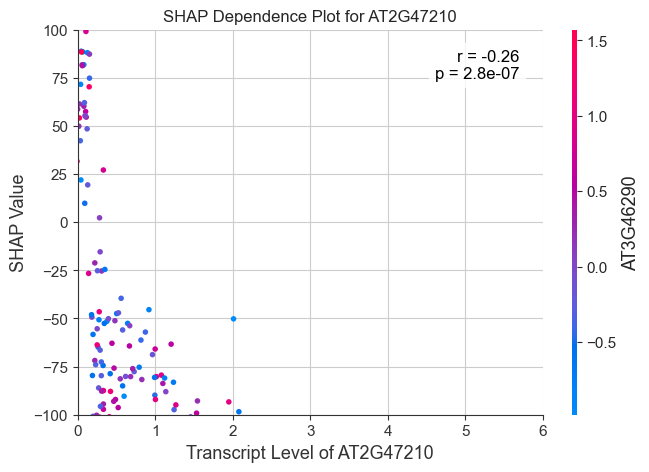

In [14]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT2G47210"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000*20

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(0, 6)
    plt.ylim(-100, 100)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

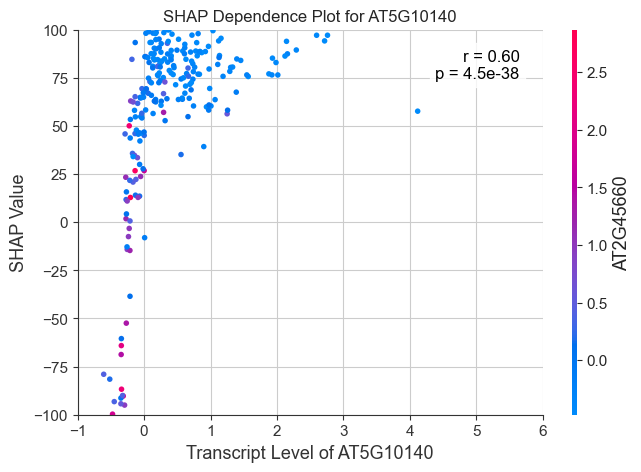

In [26]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT5G10140"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_rf_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values *10000

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)
    plt.ylim(-100, 100)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")
